In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.embeddings import Embedding
from keras.layers import Flatten
from keras.preprocessing import sequence
import seaborn as sns
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# reads all .txt files in the path given and adds them to the list
def read_files(relative_path, ls):
    files = os.listdir(relative_path)
    files = list(filter(lambda x: x[-4:] == '.txt', files))

    for file in files:
        name = relative_path + "/" + file
        with open(name, 'r') as f:
            ls.append(f.read().replace('\n', ''))


In [3]:
#reading all data from different data sets
fake_data1 = pd.read_csv("../data/Fake and real news dataset/Fake.csv")
true_data1 = pd.read_csv("../data/Fake and real news dataset/True.csv")

#from another source - obtaining the contents of each .txt file as a string
fake_data2 = []
true_data2 = []

read_files("../data/fakeNewsDatasets/fakeNewsDataset/fake", fake_data2)     
read_files("../data/fakeNewsDatasets/celebrityDataset/fake", fake_data2)
read_files("../data/fakeNewsDatasets/fakeNewsDataset/legit", true_data2)
read_files("../data/fakeNewsDatasets/celebrityDataset/legit", true_data2)




In [4]:
print("true_data1 dimensions:", true_data1.shape)
#true_data1.head()
print("fake_data1 dimensions:", fake_data1.shape)
#fake_data1.head()
#checking for invalid entries
print("true_data1 has null values:", true_data1.isnull().values.any())
print("fake_data1 has null values:", fake_data1.isnull().values.any())

true_data1 dimensions: (21417, 4)
fake_data1 dimensions: (23481, 4)
true_data1 has null values: False
fake_data1 has null values: False


In [5]:
print("Number of observations in true_data2:", len(true_data2))
print("Number of observations in fake_data2:", len(fake_data2))

Number of observations in true_data2: 490
Number of observations in fake_data2: 490


In [6]:
def plot_top_counts(titles, top, plt_title):
    unwanted = [ "to", "the", "for", "in", "of", "a", "and", "is", "says", "with", "as", "on", "at", "he", "his"]
    title_words = {}
    word = ""

    for title in titles:
        title = title.split(" ")

        for word in title:
            word = word.strip()
            word = word.strip(",")
            word = word.strip(".")
            word = word.strip("'")
            word = word.strip(":")

            if word.isalpha() and (word not in unwanted) and len(word) > 4:
                if word not in title_words:
                    title_words[word] = 1
                else:
                    title_words[word] += 1

    sorted_words = sorted(title_words.items(), key = lambda x: x[1], reverse = True)
    plotting_words = sorted_words[0:top]
    words_x = [tup[0] for tup in plotting_words]
    counts_y = [tup[1] for tup in plotting_words]

    
    
    plt.bar(range(len(plotting_words)), counts_y)
    plt.xticks(range(len(plotting_words)), words_x)
    plt.xlabel("Words")
    plt.ylabel("Counts")
    plt.title(plt_title)
    plt.show()




In [7]:
#creating dataframes
is_fake = [1 for x in range(len(fake_data1))]
fake_data1 = pd.DataFrame(list(fake_data1['text']), columns=['text'])
fake_data1['is_fake'] = is_fake
#print(fake_data1.head())

is_fake = [0 for x in range(len(true_data1))]
true_data1 = pd.DataFrame(list(true_data1['text']), columns=['text'])
true_data1['is_fake'] = is_fake
#print(true_data1.head())


is_fake = [1 for x in range(len(fake_data2))]
fake_data2 = pd.DataFrame(fake_data2, columns=['text'])
fake_data2['is_fake'] = is_fake

is_fake = [0 for x in range(len(true_data2))]
true_data2 = pd.DataFrame(true_data2, columns=['text'])
true_data2['is_fake'] = is_fake




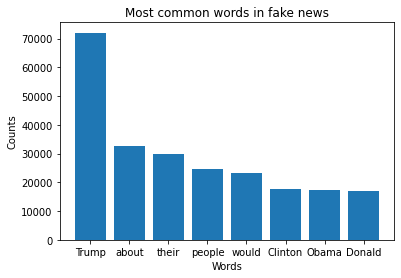

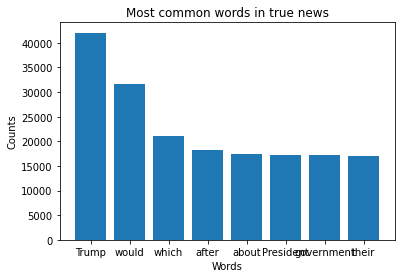

In [8]:
fake_words = list(fake_data1['text']) + list(fake_data2['text'])
true_words = list(true_data1['text']) + list(true_data2['text'])
plot_top_counts(fake_words, 8, "Most common words in fake news")
plot_top_counts(true_words, 8, "Most common words in true news")

In [9]:
#joining all data sets
frames = [true_data1, fake_data1, fake_data2, true_data2]
merged = pd.concat(frames)

merged.describe
merged = sk.utils.shuffle(merged)
print(merged.isnull().values.any())
#df.head()

False


In [10]:
#splitting data into training and tests sets
split = 0.2
train_txts, test_txts, train_res, test_res = train_test_split(merged['text'], merged['is_fake'], test_size=split, random_state=12)

In [11]:
#creating a word dictionaries where each word is assigned a unique number 
n_words = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words = n_words, filters='!""#$%&()*+,-./:;<=>?@[\\]^_`{|}\'~\t\n.', lower=True,
    split=' ', char_level=False,  oov_token=True)

tokenizer.fit_on_texts(train_txts)
train_seqs = tokenizer.texts_to_sequences(train_txts)

max_len = max(len(x) for x in train_seqs)

train_seqs = sequence.pad_sequences(train_seqs, maxlen=max_len)
test_seqs = tokenizer.texts_to_sequences(test_txts)
test_seqs = sequence.pad_sequences(test_seqs, maxlen=max_len)


In [12]:
print(max_len)
print(max(tokenizer.word_index.values()))

15404
128595


In [13]:
#building model for analysing titles
#experiment with this 
inp_dim = max(tokenizer.word_index.values()) + 1
#inp_dim = 5000
out_dim = 64

model = Sequential()
model.add(Embedding(inp_dim, out_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15404, 64)         8230144   
_________________________________________________________________
flatten (Flatten)            (None, 985856)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                31547424  
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1

In [14]:
hist = model.fit(train_seqs, train_res, validation_data=(test_seqs, test_res), epochs=3, batch_size=2000)

Epoch 1/3
19/19 [==============================] - 377s 20s/step - loss: 1.1752 - accuracy: 0.5068 - val_loss: 0.8569 - val_accuracy: 0.5210
Epoch 2/3
19/19 [==============================] - 389s 20s/step - loss: 0.6311 - accuracy: 0.6480 - val_loss: 0.4903 - val_accuracy: 0.8611
Epoch 3/3
19/19 [==============================] - 375s 20s/step - loss: 0.3589 - accuracy: 0.9060 - val_loss: 0.2402 - val_accuracy: 0.9397


Accuracy: 93.97%


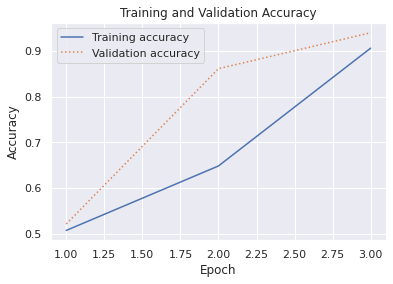

In [16]:
sns.set()
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.plot()

scores = model.evaluate(test_seqs, test_res, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

add comment about training and validation accuracy 